In [1]:
from typing import Union, Sequence
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.patches as patches
from omegaconf import OmegaConf
import hydra
from hydra import initialize_config_dir, compose
import time
import imageio


import numpy as np

import torch
import torch.nn.functional as F
from torchvision.transforms.functional import gaussian_blur

import spnf
from spnf.utils import set_seed, make_coord_grid, apply_to_tensors, to_py
from spnf.sample import (
    rand_ortho, logrand, construct_covariance, sample_gaussian_delta, sample_ellipsoid_delta
)
from spnf.trainer import Trainer

config_dir = Path(spnf.__file__).parent / "configs"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_cfg(config_name, config_dir: Path, overrides: list):
    with initialize_config_dir(version_base=None, config_dir=str(config_dir)):
        cfg = compose(config_name=config_name, overrides=overrides)
    return cfg

## Training visualization for neural fields

In [2]:
lambda_decay_start = 500
vis_steps = 800
total_steps = 2000
SRC_RES = 512
FPS = 30
VIS_PATCH_RES = 64
vis_patch_x, vis_patch_y = 190, 120
cfg = get_cfg(
    config_name="train",
    config_dir=config_dir,
    overrides=[
        f"data.grid.resize={SRC_RES}",
        "data.bounds=1.0", 
        "tensorboard=null",
        f"trainer.steps={total_steps}",
        "paths.output_dir=/home/myaldiz/Data/Experiments/spnf/${task_name}",
        f"scheduler.lr_lambda.decay_start={lambda_decay_start}",
        "trainer.compile_train_step=False",
        "trainer.mc_samples_train=0"
    ],
)
video_settings = dict(
    fps=FPS,
    codec='libx265', 
    pixelformat='yuv420p',
    ffmpeg_params=[
        '-crf', '10',          # Lower CRF = Higher Quality (10 is extremely high quality)
        '-preset', 'veryslow', # Takes longer to render, but best compression
        '-tag:v', 'hvc1',      # Critical for Apple compatibility
        '-tune', 'grain',      # Preserves noise/aliasing details
        '-x265-params', 'keyint=30:bframes=0' # Advanced Tweaks (see below)
    ]
)
dev_video_settings = video_settings | dict(
    ffmpeg_params=[
        '-crf', '20', 
        '-preset', 'fast',
        '-tag:v', 'hvc1',
        '-tune', 'grain',
    ]
)

# Create output directories
output_dir = Path(cfg.paths.output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = Path(cfg.trainer.checkpoint_dir)
checkpoint_dir.mkdir(parents=True, exist_ok=True)
video_output_dir = output_dir / "visualizations" 
video_output_dir.mkdir(parents=True, exist_ok=True)

# Save the config to output directory
OmegaConf.save(config=cfg, f=output_dir / "config_singlescale.yaml", resolve=True)

In [ ]:
checkpoint_path = checkpoint_dir / "singlescale.pth"
trainer = Trainer(cfg).to(device)
if not checkpoint_path.exists():
    # Fit the model
    trainer.fit()

    # Save the state dict
    state_dict = trainer.state_dict()
    torch.save(state_dict, str(checkpoint_path))
else:
    # Load the state dict
    trainer = Trainer(cfg).to(device)
    state_dict = torch.load(checkpoint_path, map_location=device, weights_only=False)
    trainer.load_state_dict(state_dict)
    print(f"Loaded model from {checkpoint_path}")

## Visualize the prefiltering

In [ ]:
# ============ Visualization Script: Prefiltering Demo ============
COLOR_BOX = '#D46CCD'
COLOR_POINTS = '#4E71BE'
SAMPLE_RES = 32
FPS = 30
TRANSITION_SECONDS = 1  # Time spent blurring the static image
TRAJECTORY_SECONDS = 12 # Time spent moving
TOTAL_FRAMES = FPS * (TRANSITION_SECONDS + TRAJECTORY_SECONDS)
video_output = output_dir / "visualizations" / "prefiltering_demo.mov"

# --- Constants for Blur Calculation ---
# Rule of thumb: Sigma should be roughly half the sampling spacing.
# Spacing in world units = span / SAMPLE_RES
# Image Resolution = 512. World width = 2.0 (-1 to 1).
# 1 pixel in world units = 2.0 / 512
# Sigma (pixels) = (0.5 * span / 32) / (2 / 512) = 4.0 * span
SIGMA_FACTOR = 4.0 

# --- Keyframes (Same as before) ---
keyframes = [
    (0.00, -0.5,  0.5, 0.65), 
    (0.40,  0.5,  0.5, 0.65), 
    (0.50,  0.5, -0.4, 0.95),
    (0.90, -0.5, -0.4, 0.95), 
    (1.00, -0.5,  0.5, 0.65),
]

def get_trajectory_point_time(t_global, keyframes):
    """Interpolates trajectory based on 0.0 to 1.0 progress."""
    for k in range(len(keyframes) - 1):
        t0, x0, y0, s0 = keyframes[k]
        t1, x1, y1, s1 = keyframes[k+1]
        if t0 <= t_global <= t1 + 1e-5:
            segment_duration = t1 - t0
            if segment_duration <= 1e-5: return x1, y1, s1
            local_t = np.clip((t_global - t0) / segment_duration, 0, 1)
            # Cubic ease-in-out
            smooth_t = local_t * local_t * (3 - 2 * local_t) 
            current_x = x0 + (x1 - x0) * smooth_t
            current_y = y0 + (y1 - y0) * smooth_t
            current_s = s0 + (s1 - s0) * smooth_t
            return current_x, current_y, current_s
    return keyframes[-1][1:]

def get_blur_sigma(span):
    """Calculates sigma in pixels based on current zoom level (span)."""
    return max(0.1, span * SIGMA_FACTOR)

def apply_blur(img_tensor, sigma):
    """Applies gaussian blur to the 1x3xHxW tensor."""
    if sigma <= 0.2: 
        return img_tensor
    # Kernel size must be odd and cover roughly 6*sigma
    k_size = int(6 * sigma) | 1 
    return gaussian_blur(img_tensor, kernel_size=k_size, sigma=sigma)

# --- Setup Plot ---
plt.style.use('seaborn-v0_8-white') 
fig, axs = plt.subplots(1, 2, figsize=(10, 5.5), dpi=200, constrained_layout=True)
fig.patch.set_facecolor('white')

# Prepare Base Data (Ground Truth High-Res)
# trainer.data.grid is [1, 3, 512, 512], values -1 to 1
gt_signal = trainer.data.grid.to(device)

# Initial Plot State
# We will update im_context data dynamically
initial_display = gt_signal[0].permute(1,2,0).detach().cpu().numpy()
initial_display = (initial_display * 0.5 + 0.5).clip(0, 1)

im_context = axs[0].imshow(initial_display, extent=(-1, 1, 1, -1), cmap='gray', origin='upper')
axs[0].set_title("Prefiltered Signal (Adaptive Blur)", fontsize=14, fontweight='bold', color='gray')
axs[0].axis('off')

# Box and Points
rect = patches.Rectangle((0,0), 0, 0, linewidth=2.5, edgecolor=COLOR_BOX, facecolor='none')
axs[0].add_patch(rect)
scat = axs[0].scatter([], [], s=4, c=COLOR_POINTS, edgecolors='none', alpha=0.6)

# Right Panel (Sampled Result)
dummy_data = np.zeros((SAMPLE_RES, SAMPLE_RES, 3))
im_sampled = axs[1].imshow(dummy_data, vmin=0, vmax=1, interpolation='nearest') 
axs[1].set_title("Sampled Output", fontsize=14, fontweight='bold', color=COLOR_BOX)
axs[1].axis('off')

# --- Render Loop ---
writer = imageio.get_writer(video_output, **video_settings)
print(f"Rendering {TOTAL_FRAMES} frames...")

# Pre-calculate frames split
frames_transition = FPS * TRANSITION_SECONDS
frames_trajectory = FPS * TRAJECTORY_SECONDS

for i in tqdm(range(TOTAL_FRAMES)):
    
    # === Logic Control ===
    if i < frames_transition:
        # Phase 1: Static Box, Ramp up Blur
        progress = i / frames_transition
        # Ease out for smooth transition
        progress = np.sin(progress * np.pi / 2) 
        
        cx, cy, span = keyframes[0][1:] # Fixed at start pos
        
        target_sigma = get_blur_sigma(span)
        current_sigma = target_sigma * progress
        
    else:
        # Phase 2: Move Box, Adaptive Blur
        traj_progress = (i - frames_transition) / (frames_trajectory - 1)
        cx, cy, span = get_trajectory_point_time(traj_progress, keyframes)
        
        # Sigma adapts instantly to span (zoom level)
        current_sigma = get_blur_sigma(span)

    # 1. Blur the underlying signal
    blurred_signal = apply_blur(gt_signal, current_sigma)
    
    # 2. Get coords for sampling box
    bounds = (cx - span/2, cy - span/2, cx + span/2, cy + span/2)
    
    # Generate sampling grid (1, H, W, 2) in range [-1, 1] for grid_sample
    # Note: make_coord_grid usually returns coordinates in world space (e.g. bounded by bounds).
    # We need to normalize these world coordinates back to [-1, 1] relative to the whole image
    # to use grid_sample on the full image.
    
    # Grid for the small patch
    grid_coords_world = spnf.utils.make_coord_grid(
        ndim=2, resolution=SAMPLE_RES, bounds=bounds, device=device
    ) # shape (SAMPLE_RES, SAMPLE_RES, 2)
    
    # grid_sample expects (1, H, W, 2) where coords are in [-1, 1]
    # Since our world is [-1, 1], we can just use the world coords directly.
    grid_sample_input = grid_coords_world.unsqueeze(0) 

    # 3. Sample from the BLURRED image (Prefiltering Operation)
    # This replaces the neural network query
    sampled_patch = F.grid_sample(
        blurred_signal, 
        grid_sample_input, 
        mode='bilinear', 
        align_corners=False
    ) # Returns (1, 3, SAMPLE_RES, SAMPLE_RES)

    # 4. Prepare Data for Visualization
    
    # Left Panel: Show the full blurred image
    vis_full = blurred_signal[0].permute(1,2,0).clamp(-1, 1).add(1).div(2).cpu().numpy()
    
    # Right Panel: Show the sampled patch
    vis_patch = sampled_patch[0].permute(1,2,0).clamp(-1, 1).add(1).div(2).cpu().numpy()
    
    # 5. Update Artists
    im_context.set_data(vis_full)
    im_sampled.set_data(vis_patch)
    
    rect.set_xy((bounds[0], bounds[1])) 
    rect.set_width(span)
    rect.set_height(span)
    
    c_np = grid_coords_world.view(-1, 2).cpu().numpy()
    scat.set_offsets(c_np)
    
    # 6. Capture Frame
    fig.canvas.draw()
    frame = np.asarray(fig.canvas.buffer_rgba())
    writer.append_data(frame)

writer.close()
plt.close()
print(f"Done. Saved {video_output}")

## Visualize network with identity encoding

In [3]:
cfg = get_cfg(
    config_name="train",
    config_dir=config_dir,
    overrides=[
        f"data.grid.resize={SRC_RES}",
        "data.bounds=1.0", 
        "tensorboard=null",
        f"trainer.steps={total_steps}",
        "paths.output_dir=/home/myaldiz/Data/Experiments/spnf/${task_name}",
        f"scheduler.lr_lambda.decay_start={lambda_decay_start}",
        "trainer.compile_train_step=False",
        "trainer.mc_samples_train=0",
        "model.encoder._target_=spnf.encoding.IdentityEncoding",
        "model.mlp.input_dim=2"
    ],
)

# Save the config to output directory
OmegaConf.save(config=cfg, f=output_dir / "config_noencoding.yaml", resolve=True)

In [5]:
vis_steps = 2000
VIS_PATCH_RES = 64
vis_patch_x, vis_patch_y = 190, 120
trainer = Trainer(cfg).to(device)

loss_average = []
predictions = []
steps_history = []  # New: Track the actual step number for the X-axis

current_step = 0
frame_count = 0
pbar = tqdm(total=vis_steps, desc="Training identity encoding")

while current_step < vis_steps:
    # Determine stride based on how many frames we have generated
    if current_step < 30:
        stride = 1
    elif current_step < 90:
        stride = 2
    else:
        stride = 10
        
    # Ensure we don't exceed vis_steps
    if current_step + stride > vis_steps:
        stride = vis_steps - current_step
        if stride == 0: break

    # Fit for 'stride' steps
    stats = trainer.fit(num_steps=stride, no_tqdm=True)
    
    # Update trackers
    current_step += stride
    frame_count += 1
    pbar.update(stride)

    # Store Data
    loss_average.append(np.mean(stats['mse_loss']))
    steps_history.append(current_step) # Store actual X-axis location
    
    # Generate visualization
    output = trainer.generate_grid_data(resolution=SRC_RES)
    predictions.append(output["filtered_signal"].clamp(-1.0, 1.0).add(1.0).div(2.0).cpu().numpy())

pbar.close()

# --- VIDEO GENERATION ---
video_output = output_dir / "visualizations" / "identityencoding_train_vis.mov"
video_patch_output = output_dir / "visualizations" / "identityencoding_train_vis_patch.mov"
writer = imageio.get_writer(
    video_output, 
    **video_settings
)
writer_patch = imageio.get_writer(
    video_patch_output, 
    **video_settings
)

# Settings
plt.style.use('default') 
max_loss = max(loss_average) * 1.1

# 1. Geometry Calculation
sample = predictions[0]
if sample.ndim == 3 and sample.shape[0] in [1, 3]:
    h, w = sample.shape[1], sample.shape[2]
else:
    h, w = sample.shape[0], sample.shape[1]

fig_width = 12 
img_height_in = fig_width * (h / w)
loss_height_in = 4.0 
total_height = img_height_in + loss_height_in

# Calculate relative height ratios for manual positioning
h_img_ratio = img_height_in / total_height
h_loss_ratio = loss_height_in / total_height

print("Rendering video frames...")
# Zip with steps_history to get the correct X-axis value
for i, (loss, pred, step_num) in enumerate(tqdm(zip(loss_average, predictions, steps_history), total=len(predictions))):
    
    # Create figure without subplots/layouts to allow manual placement
    fig = plt.figure(figsize=(fig_width, total_height), dpi=100)
    
    # Bottom Plot
    margin_bottom = 0.08
    h_loss_actual = h_loss_ratio - margin_bottom - 0.02
    ax_loss = fig.add_axes([0.12, margin_bottom, 0.82, h_loss_actual])
    
    margin_top = 0.02
    y_img_start = h_loss_ratio + 0.02
    h_img_actual = h_img_ratio - margin_top - 0.02
    ax_img = fig.add_axes([0.02, y_img_start, 0.96, h_img_actual])

    # --- 1. Image Plot ---
    if pred.ndim == 3 and pred.shape[0] in [1, 3]: 
        pred = np.transpose(pred, (1, 2, 0))
    
    ax_img.imshow(pred, aspect='auto') 
    
    # Hide all ticks/spines for the image
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    for spine in ax_img.spines.values():
        spine.set_visible(False) 
    
    # --- 2. Loss Plot ---
    # MODIFICATION: Use steps_history for X-axis data
    current_steps_data = steps_history[:i+1]
    current_loss_data = loss_average[:i+1]
    
    ax_loss.plot(current_steps_data, current_loss_data, color='tab:blue', linewidth=3)
    
    # MODIFICATION: Use step_num (the actual training step) for the scatter X-coordinate
    ax_loss.scatter(step_num, loss, color='tab:red', s=100, zorder=5) 
    
    # MODIFICATION: Set X limit to the total vis_steps (800) rather than frame count
    ax_loss.set_xlim(0, vis_steps)
    ax_loss.set_ylim(0, max_loss)
    
    ax_loss.set_ylabel('MSE Loss', fontsize=24, labelpad=15, fontweight='medium')
    ax_loss.set_xlabel('Steps', fontsize=18) # Optional: Label x-axis
    ax_loss.tick_params(axis='both', which='major', labelsize=16)
    ax_loss.grid(True, linestyle='--', alpha=0.5, linewidth=1.5)

    # --- 3. Save Frame ---
    fig.canvas.draw()
    frame = np.array(fig.canvas.buffer_rgba())
    
    writer.append_data(frame)
    patch = pred[vis_patch_y:vis_patch_y+VIS_PATCH_RES, vis_patch_x:vis_patch_x+VIS_PATCH_RES]
    
    writer_patch.append_data((patch * 255).astype(np.uint8))
    plt.close(fig)

writer.close()
writer_patch.close()
print(f"Videos are saved: {video_output}, {video_patch_output}")

# Save last frame patch as PNG
last_frame_output = output_dir / "visualizations" / "identityencoding_train_vis_patch.png"
patch = predictions[-1][vis_patch_y:vis_patch_y+VIS_PATCH_RES, vis_patch_x:vis_patch_x+VIS_PATCH_RES]
imageio.imwrite(
    last_frame_output, 
    (patch * 255).astype(np.uint8)
)
print(f"Last frame image saved: {last_frame_output}")

Training identity encoding:   0%|          | 0/2000 [00:00<?, ?it/s]

Rendering video frames...


  0%|          | 0/251 [00:00<?, ?it/s]

x265 [info]: HEVC encoder version 3.5+1-f0c1022b6
x265 [info]: build info [Linux][GCC 8.3.0][64 bit] 8bit+10bit+12bit
x265 [info]: using cpu capabilities: MMX2 SSE2Fast LZCNT SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
x265 [info]: Main profile, Level-4 (Main tier)
x265 [info]: Thread pool created using 24 threads
x265 [info]: Slices                              : 1
x265 [info]: frame threads / pool features       : 4 / wpp(25 rows)
x265 [info]: Coding QT: max CU size, min CU size : 64 / 8
x265 [info]: Residual QT: max TU size, max depth : 32 / 3 inter / 3 intra
x265 [info]: ME / range / subpel / merge         : star / 57 / 4 / 5
x265 [info]: Keyframe min / max / scenecut / bias  : 3 / 30 / 40 / 5.00 
x265 [info]: Lookahead / bframes / badapt        : 40 / 0 / 2
x265 [info]: b-pyramid / weightp / weightb       : 0 / 1 / 1
x265 [info]: References / ref-limit  cu / depth  : 5 / off / off
x265 [info]: Rate Control / qCompress            : CRF-10.0 / 0.60
x265 [info]: tools: rect amp rd=6 psy-rd=4.00 

Videos are saved: /home/myaldiz/Data/Experiments/spnf/spnf-oia/visualizations/identityencoding_train_vis.mov, /home/myaldiz/Data/Experiments/spnf/spnf-oia/visualizations/identityencoding_train_vis_patch.mov
Last frame image saved: /home/myaldiz/Data/Experiments/spnf/spnf-oia/visualizations/identityencoding_train_vis_patch.png


x265 [info]: frame I:      9, Avg QP:3.89  kb/s: 169.92  
x265 [info]: frame P:    242, Avg QP:3.94  kb/s: 76.20   
x265 [info]: Weighted P-Frames: Y:3.7% UV:0.0%
x265 [info]: consecutive B-frames: 100.0% 

encoded 251 frames in 118.86s (2.11 fps), 79.56 kb/s, Avg QP:3.94


## Kernel closed form solutions

In [18]:
import torch
import cv2
import numpy as np

def render_kernel(kind, cov_mat, interval=(-3.0, 3.0), res=1024, a=1.0, colormap=None, fourier=False):
    device = cov_mat.device
    lo, hi = float(interval[0]), float(interval[1])
    x = torch.linspace(lo, hi, res, device=device)
    grid = torch.stack(torch.meshgrid(x, x, indexing='xy'), dim=-1).reshape(-1, 2)

    # Calculate quadratic form
    if fourier:
        # Fourier metric uses Sigma directly (Eq 10, 11, 12): b^T Sigma b
        q = (grid @ cov_mat * grid).sum(-1)
    else:
        # Spatial metric uses Sigma inverse: x^T Sigma^-1 x
        inv_cov = torch.linalg.inv(cov_mat)
        q = (grid @ inv_cov * grid).sum(-1)

    kind = kind.lower()
    
    if kind == 'gaussian':
        if fourier:
            # Eq 10: exp(-2 * pi^2 * b^T Sigma b)
            val = torch.exp(-2 * (torch.pi**2) * q)
        else:
            val = torch.exp(-0.5 * q)
        ker01 = val.clamp(0, 1)

    elif kind == 'uniform_ellipsoid': # Box
        if fourier:
            # Eq 29: Jinc function shape -> J1(2*pi*sqrt(q)) / (pi*sqrt(q))
            arg = 2 * torch.pi * q.sqrt()
            # J1(x)/x limit at 0 is 0.5. We normalize peak to 1.
            val = torch.nan_to_num(torch.special.bessel_j1(arg) / arg, nan=0.5)
            val = val / 0.5 
            ker01 = val.abs().clamp(0, 1) # Abs to visualize ringing lobes
        else:
            ker01 = (q.sqrt() < 1).float()

    elif kind == 'lanczos':
        if fourier:
            # Eq 12: Trapezoid function
            term = q.sqrt()
            clip_high = min(1.0, 1.0 / a)
            # max(min( (a+1)/2a - term, clip_high), 0)
            val = torch.clamp(torch.min((a + 1)/(2 * a) - term, torch.tensor(clip_high, device=device)), min=0)
            ker01 = val / val.max() if val.max() > 0 else val
        else:
            t = q.sqrt()
            ker = torch.sinc(t) * torch.sinc(t / a)
            # Preserving your visualization tricks
            ker = ker / torch.max(ker.abs()) * 2.5
            ker01 = ker.clamp(-1, 1).abs().clamp(0, 1)
    else:
        raise ValueError("kind must be 'gaussian', 'uniform_ellipsoid', or 'lanczos'")

    img_u8 = (ker01.reshape(res, res) * 255).round().to(torch.uint8).cpu().numpy()
    
    if colormap is not None:
        return cv2.applyColorMap(img_u8, colormap)
    return cv2.cvtColor(img_u8, cv2.COLOR_GRAY2BGR)

def plot_kernel_1d(kind, sigma, interval=(-3.0, 3.0), res=1024, a=1.0, ax=None, fourier=False, color='blue'):
    if ax is None:
        fig, ax = plt.subplots()
    
    device = torch.device('cpu') # 1D plotting is light, cpu is fine
    lo, hi = float(interval[0]), float(interval[1])
    t = torch.linspace(lo, hi, res, device=device)
    
    # In 1D, Mahalanobis distance sqrt(x^T Sigma^-1 x) simplifies to |t|/sigma
    # For Fourier, sqrt(b^T Sigma b) simplifies to |t|*sigma
    dist = t.abs() / sigma if not fourier else t.abs() * sigma
    
    kind = kind.lower()
    
    if kind == 'gaussian':
        if fourier:
            # Eq 10: exp(-2 * pi^2 * b^T Sigma b)
            y = torch.exp(-2 * (torch.pi**2) * (dist**2))
        else:
            y = torch.exp(-0.5 * (dist**2))
            
    elif kind == 'uniform_ellipsoid': # Box
        if fourier:
            # Eq 11 (1D case): Sinc(2 * freq * sigma)
            # torch.sinc(x) is sin(pi*x)/(pi*x), so we need argument 2*dist
            y = torch.sinc(2 * dist)
        else:
            y = (dist <= 1.0).float()
            
    elif kind == 'lanczos':
        if fourier:
            # Eq 12 & 35: Trapezoid function
            # max(min( (a+1)/2a - dist, min(1, 1/a) ), 0)
            clip_val = min(1.0, 1.0 / a)
            ramp = (a + 1) / (2 * a) - dist
            y = torch.clamp(torch.min(ramp, torch.tensor(clip_val)), min=0)
            # Normalize peak to 1 for visualization
            if y.max() > 0: y = y / y.max()
        else:
            # Spatial 1D Lanczos
            # sinc(x) * sinc(x/a)
            y = torch.sinc(dist) * torch.sinc(dist / a)
            # Applying your requested visibility tricks
            y = y / torch.max(y.abs())
            
    else:
        raise ValueError("kind must be 'gaussian', 'uniform_ellipsoid', or 'lanczos'")

    # Plotting
    ax.plot(t.numpy(), y.numpy(), color=color, linewidth=2)
    ax.set_ylim(-0.225, 1.1)
    ax.set_xlim(lo, hi)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"{kind.capitalize()} ({'Fourier' if fourier else 'Spatial'})")

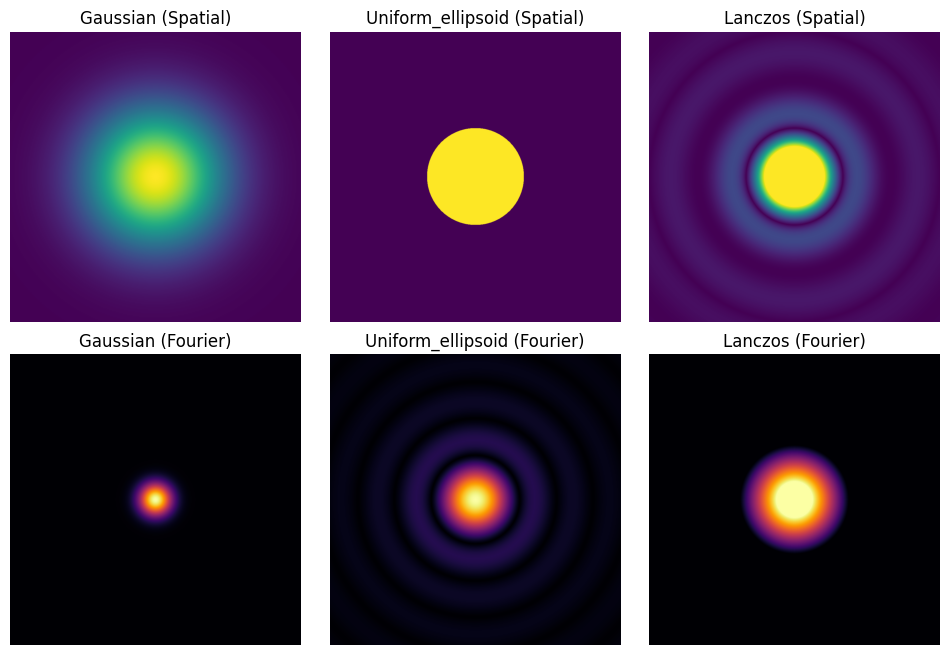

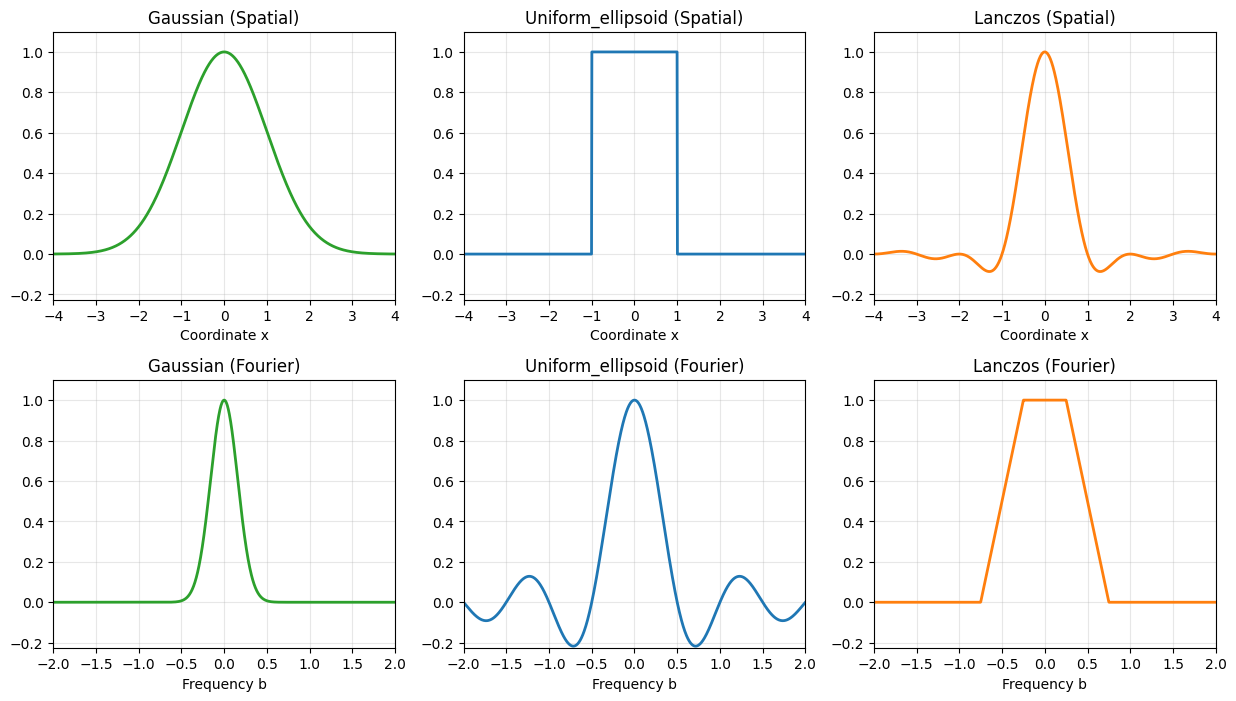

In [19]:
import matplotlib.pyplot as plt

# Setup: Isotropic covariance (identity)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cov = torch.eye(2, device=device) * 1.0
lanczos_a = 2.0

kernels = ['gaussian', 'uniform_ellipsoid', 'lanczos']
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, k in enumerate(kernels):
    # Spatial Render
    img_spatial = render_kernel(k, cov, interval=(-3, 3), a=lanczos_a, colormap=cv2.COLORMAP_VIRIDIS, fourier=False)
    # Fourier Render
    img_fourier = render_kernel(k, cov, interval=(-2, 2), a=lanczos_a, colormap=cv2.COLORMAP_INFERNO, fourier=True)
    
    # Plotting
    axes[0, i].imshow(img_spatial[..., ::-1]) # BGR to RGB
    axes[0, i].set_title(f"{k.capitalize()} (Spatial)")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(img_fourier[..., ::-1])
    axes[1, i].set_title(f"{k.capitalize()} (Fourier)")
    axes[1, i].axis('off')

plt.show()

# Parameters
sigma = 1.0
kernels = ['gaussian', 'uniform_ellipsoid', 'lanczos']
colors = ['tab:green', 'tab:blue', 'tab:orange']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plt.subplots_adjust(hspace=0.3)

# Row 1: Spatial Domain (x)
for i, (k, c) in enumerate(zip(kernels, colors)):
    plot_kernel_1d(k, sigma, interval=(-4, 4), a=lanczos_a, 
                   ax=axes[0, i], fourier=False, color=c)
    axes[0, i].set_xlabel("Coordinate x")

# Row 2: Frequency Domain (b)
for i, (k, c) in enumerate(zip(kernels, colors)):
    plot_kernel_1d(k, sigma, interval=(-2, 2), a=lanczos_a, 
                   ax=axes[1, i], fourier=True, color=c)
    axes[1, i].set_xlabel("Frequency b")

plt.show()